# Long Short-Term Memory (LSTM) Analysis

- **Date Started:** May 9th, 2024
- **Author:** Ephraim Sun

## General Overview

Price prediction models are essential for investors and traders seeking to forecast future cryptocurrency prices. One method to do so is Long Short-Term Memory (LSTM).

LSTM is a deep learning, sequential neural network that allows information to persist (1). They are a special type of Recurrent Neural Networks, where it uses previous information to process for the current input. However, RNNs cannot remember long-term dependencies due to vanishing gradient, so LSTM solves this problem.

LSTM utilizes feedback corporation, allowing it to process entire sequences of data, not just individual points. 


## Imports and Setup


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, Input
from tensorflow.keras.models import Sequential
import yfinance as yf

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

## Data Fetching

We decided to retrieve the top 10 best cryptocurrencies based on market cap as of 05/11/2024. We have excluded stablecoins like Tether (USDT) and USDC. Therefore, we have the following coins in order of market capitalization (excluding stablecoins): 
1) Bitcoin (BTC)
2) Ethereum (ETH)
3) Solana (SOL)
4) Binance Coin (BNB)
5) XRP (XRP)
6) Toncoin (TON)
7) Dogecoin (DOGE)
8) Cardano (ADA)
9) Shiba Inu (SHIB)
10) Avalanche (AVAX)

From the above list, we notice that we have the two main cryptocurrencies Bitcoin and Ethereum, with Bitcoin around $1.2 trillion in value (according to CoinMarketCap) and Ethereum hovering around $3.5 billion, about 3x less the value compared to Bitcoin. In addition, we have 

In [10]:
# Define the list of top 10 cryptocurrencies
currencies = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'BNB-USD', 'XRP-USD', 'TON-USD', 'DOGE-USD', 'ADA-USD', 'SHIB-USD', 'AVAX-USD']

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2024-01-01'

data_filepath = './data'

# Fetch historical data for each cryptocurrency
for crypto_symbol in currencies:
    # Fetch historical data using yfinance
    crypto_data = yf.download(crypto_symbol, start=start_date, end=end_date)
    
    # Save data to a CSV file
    file_name = os.path.join(data_filepath, f"{crypto_symbol}_data.csv")
    crypto_data.to_csv(file_name)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Cryptocurrency Model

In [11]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)


# Function to preprocess data
def preprocess_data(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test


In [12]:
SEQ_LEN = 100
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
scaler = MinMaxScaler()
BATCH_SIZE = 64

# Function to train a model
def train_model(X_train, y_train, X_test, y_test):
    

    input_shape = (WINDOW_SIZE, X_train.shape[-1])
    inputs = Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
    model.add(Dropout(rate=DROPOUT))
    model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1)
    return model, history


In [13]:
# Function to plot loss history
def plot_loss(history, scaler, currency, df):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f"{currency} Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def predict_and_plot(model, X_test, y_test, scaler, currency, df):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    
    # Get the original dates from the dataframe
    dates = df['Date'].values[-len(y_test_inverse):]
    
    # Plotting
    plt.plot(dates, y_test_inverse, label="Actual Price", color='green')
    plt.plot(dates, y_hat_inverse, label=f"{currency} Price", color='red')
    plt.title(f"{currency} Price")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')

    # Slant the dates on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    
    plt.show()


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - loss: 0.1361 - val_loss: 0.0212
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 436ms/step - loss: 0.0339 - val_loss: 0.0617
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 437ms/step - loss: 0.0615 - val_loss: 0.0116
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - loss: 0.0184 - val_loss: 0.0293
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - loss: 0.0223 - val_loss: 0.0048
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - loss: 0.0110 - val_loss: 0.0014
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - loss: 0.0045 - val_loss: 8.9671e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - loss: 0.0040 - va

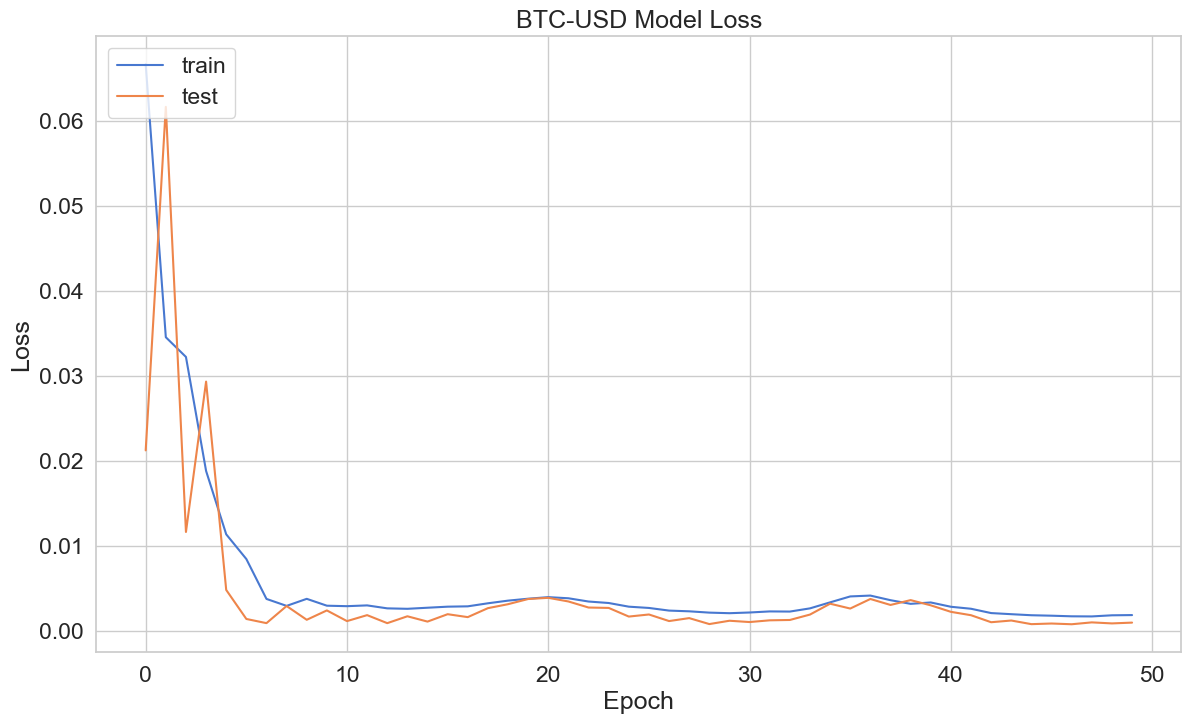

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


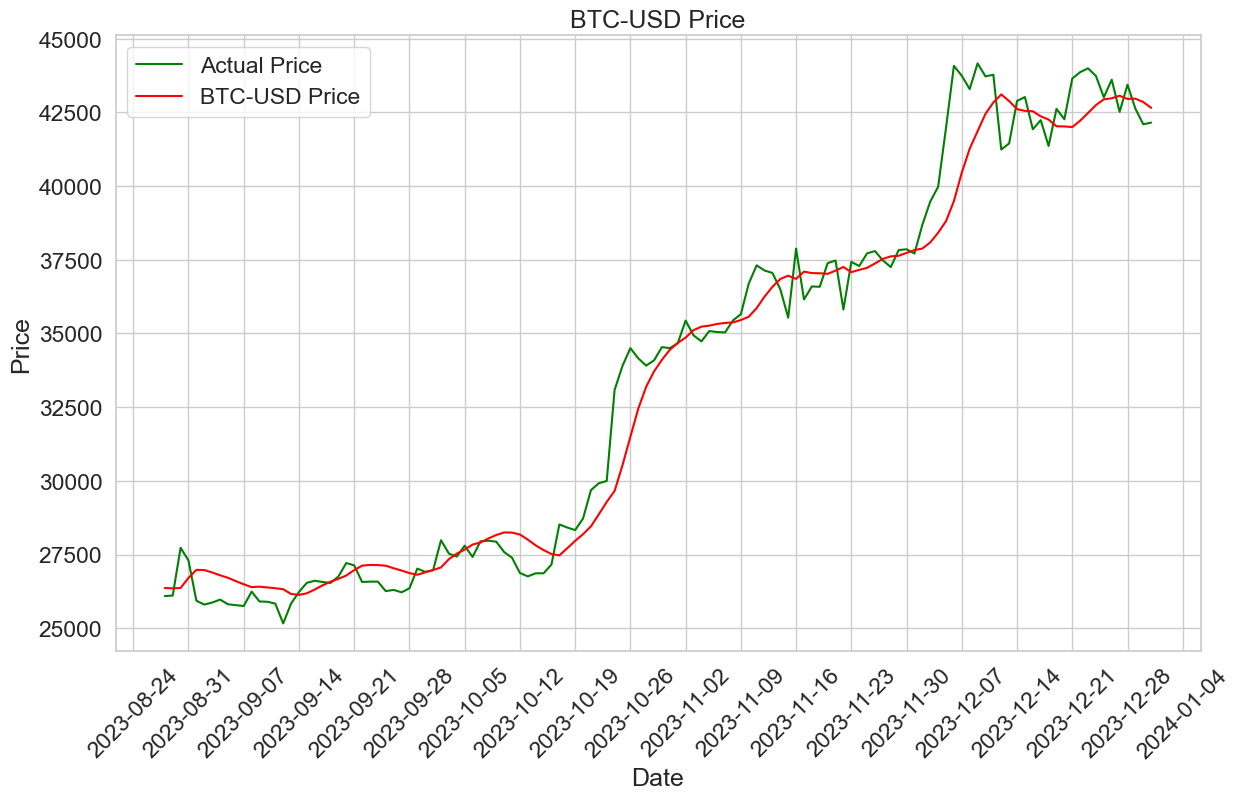

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 633ms/step - loss: 0.1023 - val_loss: 0.0045
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - loss: 0.0162 - val_loss: 0.0092
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - loss: 0.0234 - val_loss: 0.0017
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - loss: 0.0075 - val_loss: 0.0126
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - loss: 0.0166 - val_loss: 0.0055
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step - loss: 0.0076 - val_loss: 0.0012
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - loss: 0.0039 - val_loss: 3.7490e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.0029 - val_loss: 3.9616e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.0029 - val_loss: 3.0850e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - loss: 0.0026 - val_loss: 3.1056e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - loss:

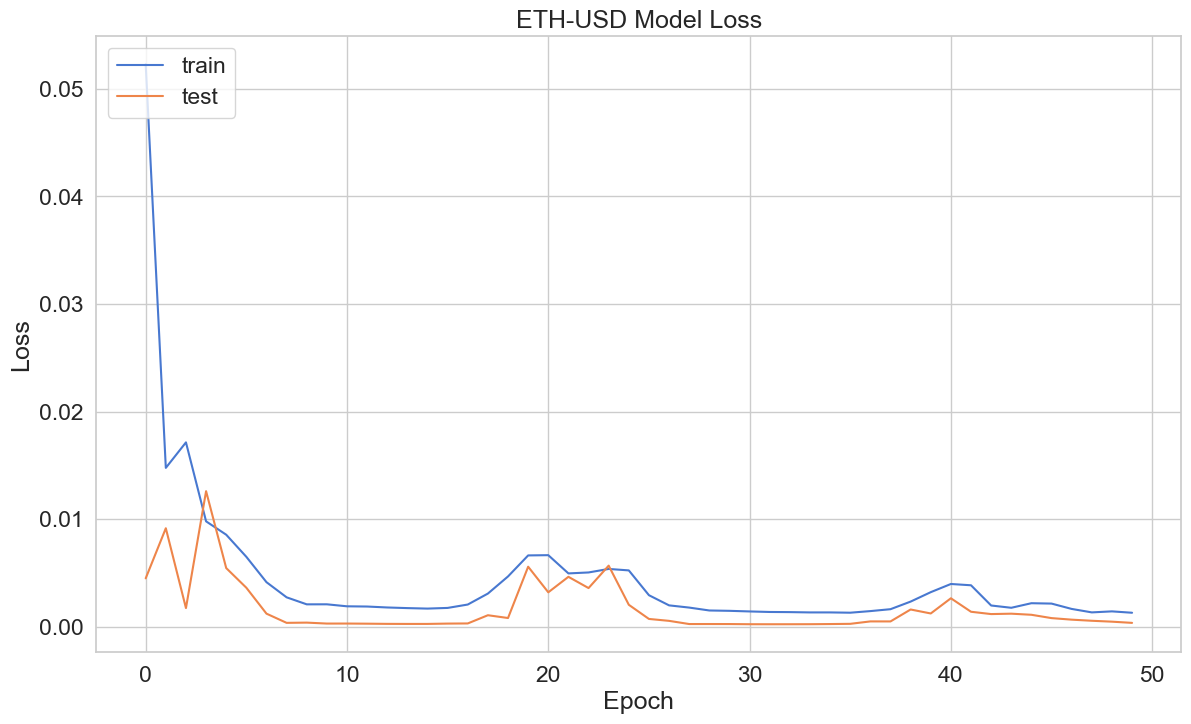

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step


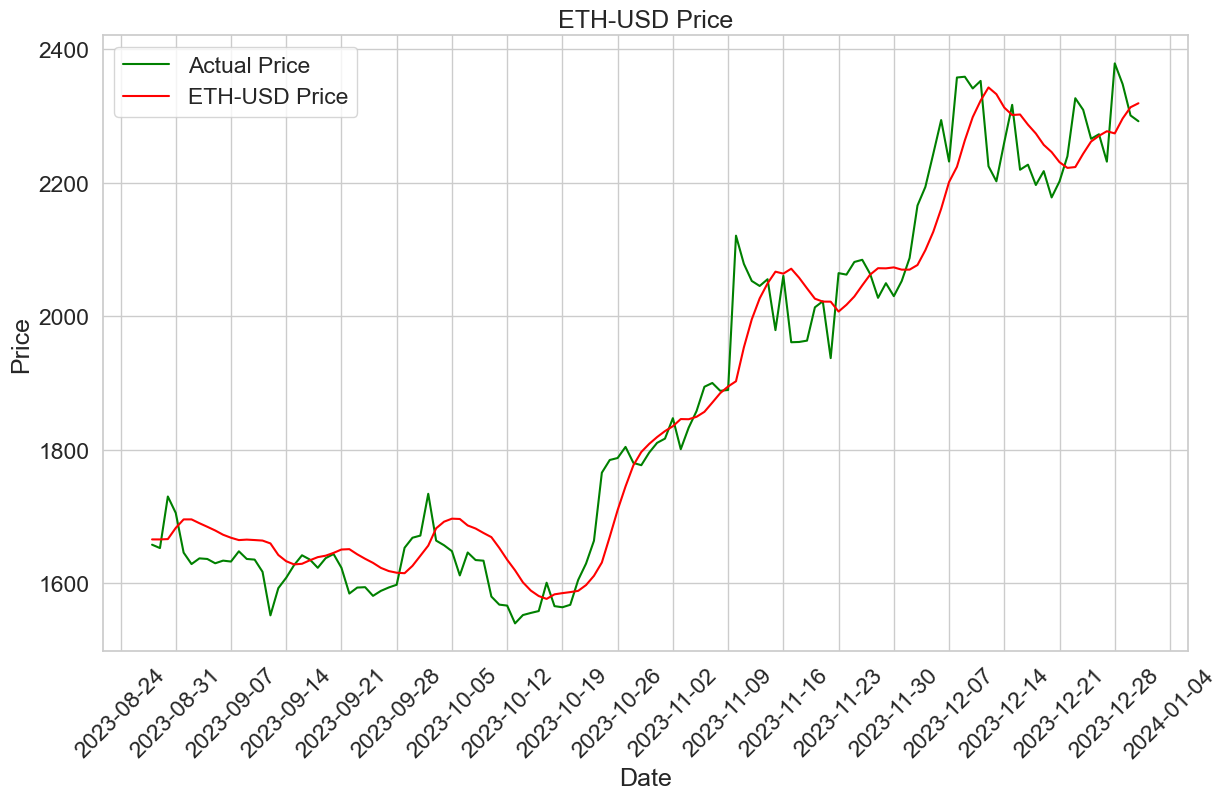

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - loss: 0.0503 - val_loss: 0.0031
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - loss: 0.0102 - val_loss: 2.2343e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.0311 - val_loss: 0.0063
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - loss: 0.0368 - val_loss: 0.0012
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step - loss: 0.0089 - val_loss: 1.2336e-04
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - loss: 0.0028 - val_loss: 2.2290e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - loss: 0.0083 - val_loss: 2.3204e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - loss: 0.0034 - val_loss: 2.0386e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 438ms/step - loss: 0.0018 - val_loss: 9.1927e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step

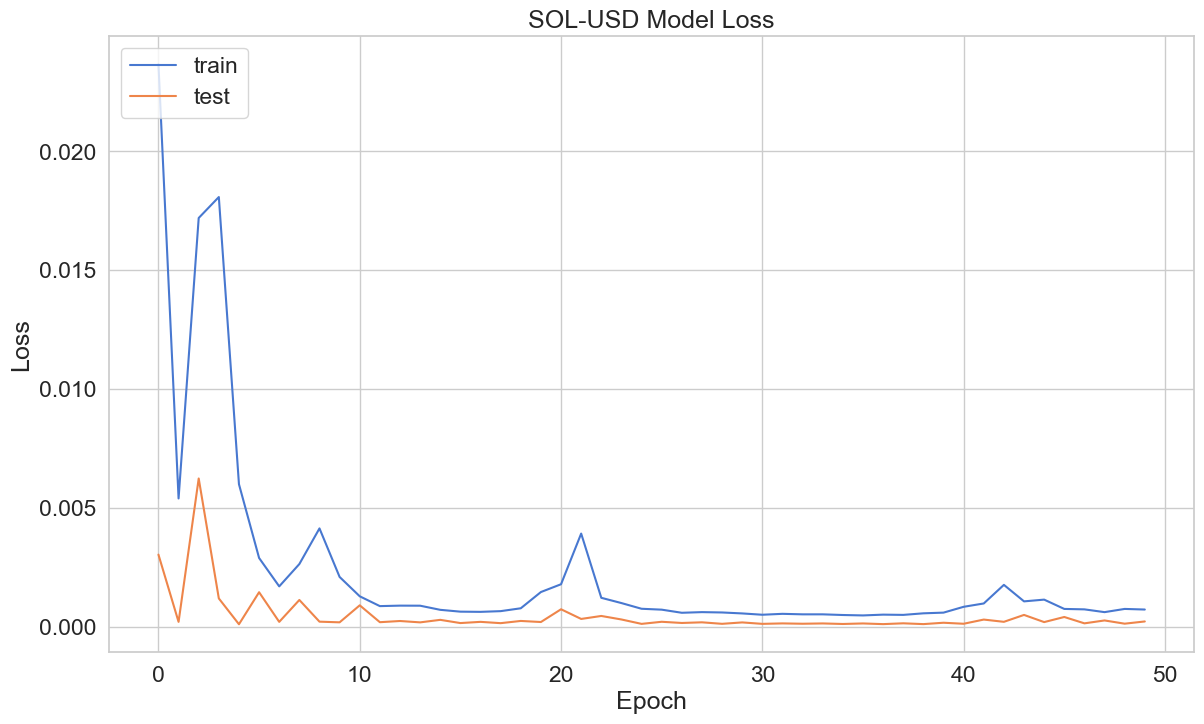

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


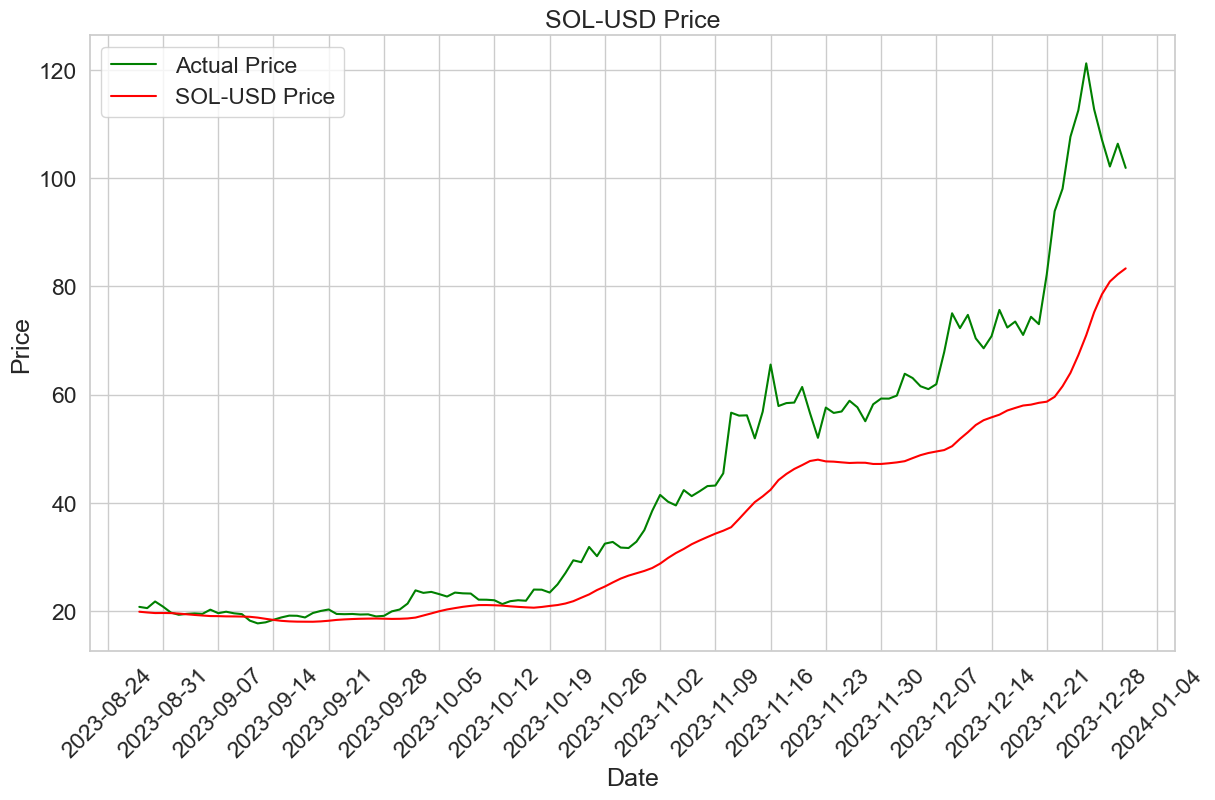

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - loss: 0.0747 - val_loss: 0.0058
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - loss: 0.0108 - val_loss: 0.0088
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - loss: 0.0141 - val_loss: 8.5165e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - loss: 0.0105 - val_loss: 0.0032
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - loss: 0.0055 - val_loss: 0.0024
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - loss: 0.0045 - val_loss: 7.1764e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - loss: 0.0038 - val_loss: 8.1825e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - loss: 0.0035 - val_loss: 9.4404e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 522ms/step - loss:

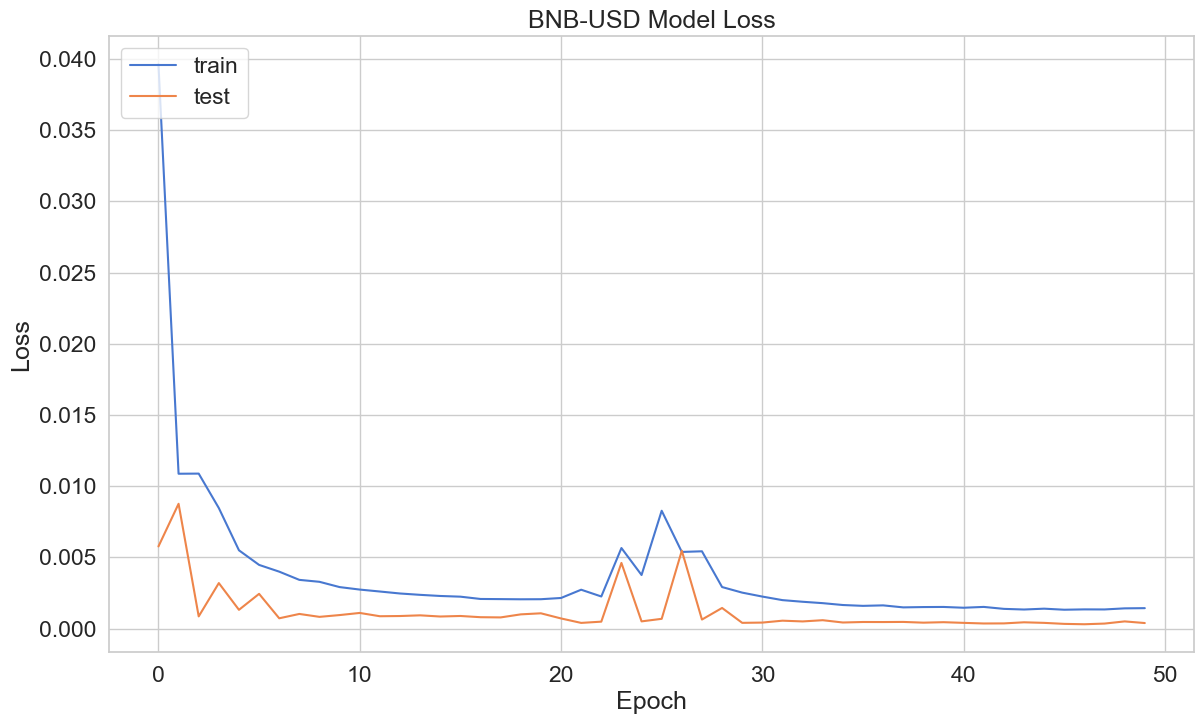

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


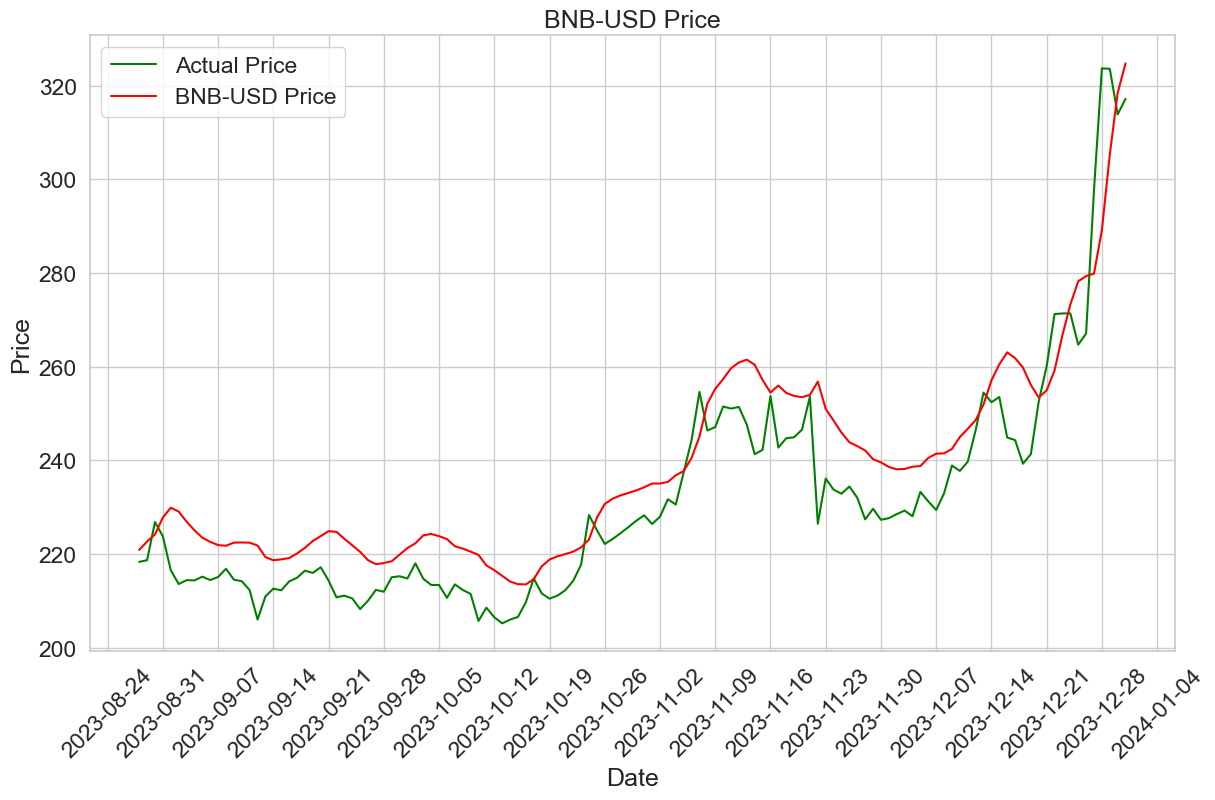

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 580ms/step - loss: 0.0938 - val_loss: 0.0459
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 499ms/step - loss: 0.0206 - val_loss: 0.0911
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - loss: 0.0229 - val_loss: 0.0303
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step - loss: 0.0107 - val_loss: 0.0991
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - loss: 0.0165 - val_loss: 0.0297
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - loss: 0.0077 - val_loss: 0.0359
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - loss: 0.0047 - val_loss: 0.0342
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - loss: 0.0046 - val_loss: 0.0280
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - loss: 0.0046 - val_loss: 0.0336
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 485ms/step - loss: 0.0042 - val_loss: 0.0259
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 484ms/step - loss: 0.0040 - val_loss: 0.0305
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - loss: 0.0039 - val_lo

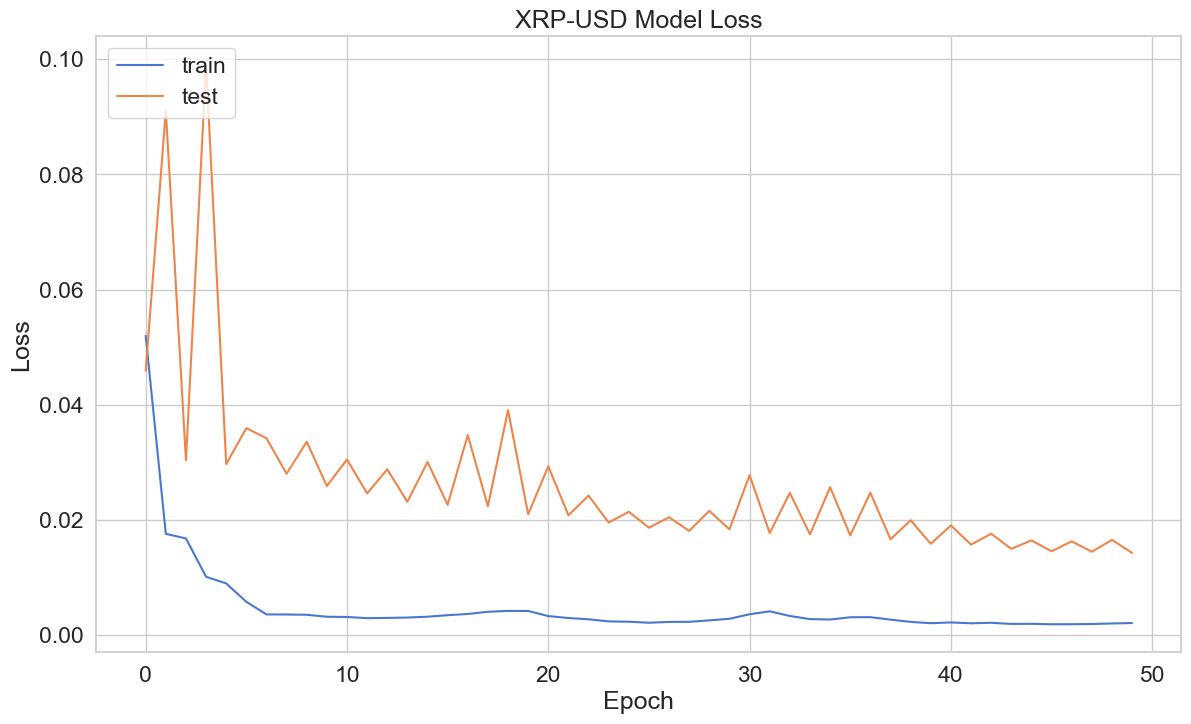

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step


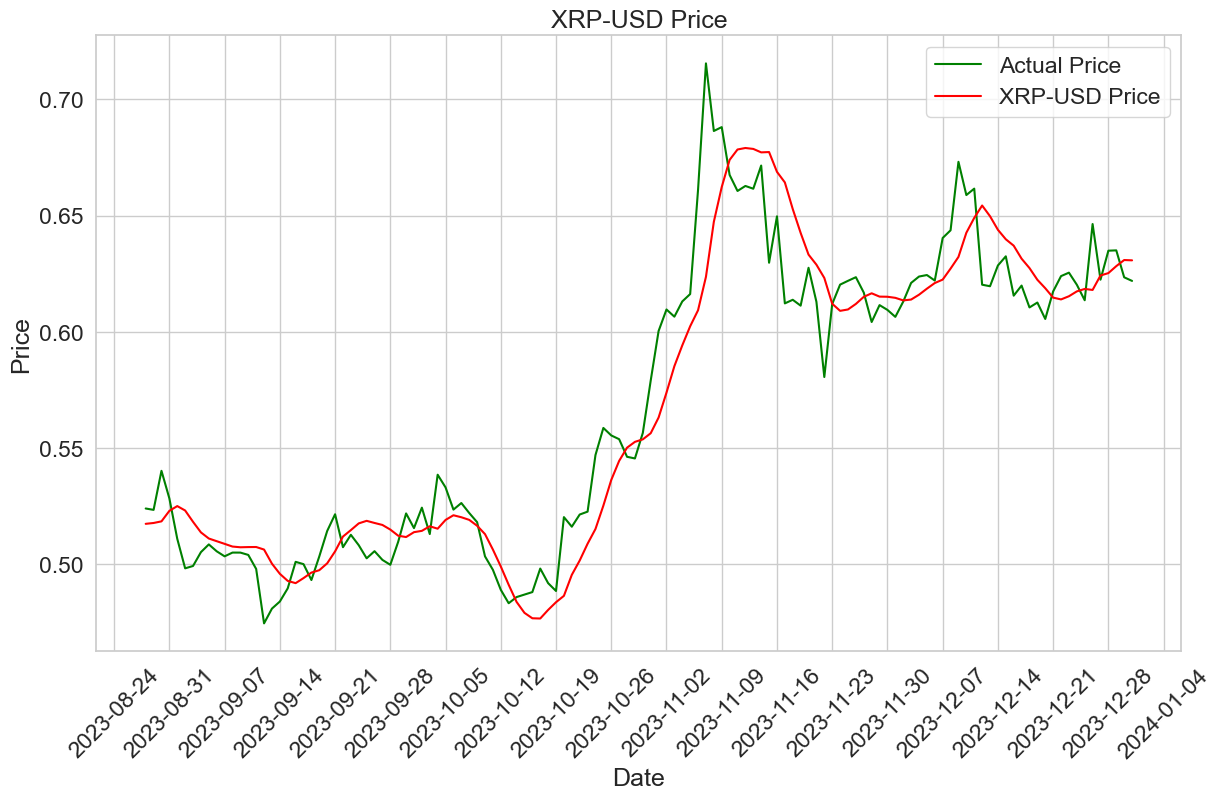

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 916ms/step - loss: 0.0761 - val_loss: 2.0709e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - loss: 0.0063 - val_loss: 3.4513e-04
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - loss: 0.0136 - val_loss: 7.9250e-04
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - loss: 0.0354 - val_loss: 0.0074
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - loss: 0.0061 - val_loss: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 0.0140 - val_loss: 0.0020
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - loss: 0.0046 - val_loss: 1.6038e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 447ms/step - loss: 0.0030 - val_loss: 1.6180e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - loss: 0.0023 - val_loss: 2.5667e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - loss: 0.0024 - val_loss: 1.8270e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - loss: 0.0024 - val_loss: 4.0849e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 5

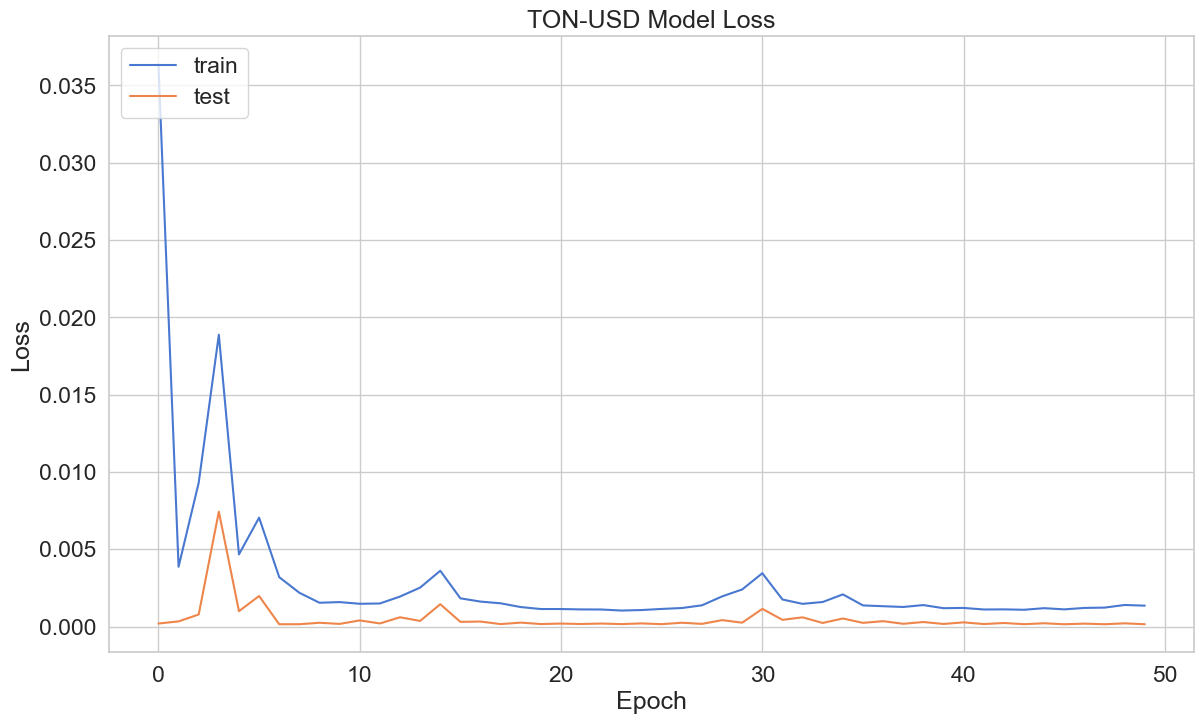

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step


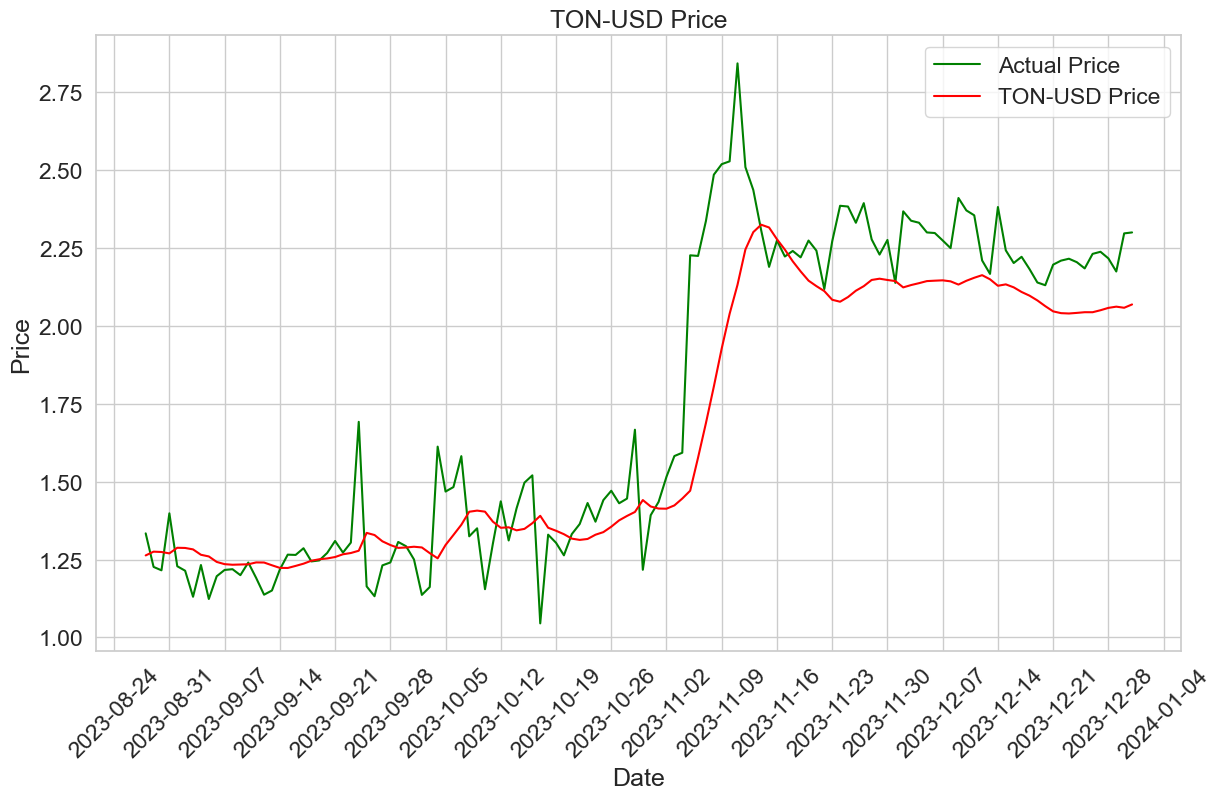

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 630ms/step - loss: 0.0902 - val_loss: 0.0012
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 763ms/step - loss: 0.0110 - val_loss: 0.0066
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 780ms/step - loss: 0.0296 - val_loss: 0.0030
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - loss: 0.0406 - val_loss: 0.0087
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 611ms/step - loss: 0.0120 - val_loss: 0.0017
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 550ms/step - loss: 0.0139 - val_loss: 0.0022
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 626ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step - loss: 0.0051 - val_loss: 9.8662e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step - loss: 0.0044 - v

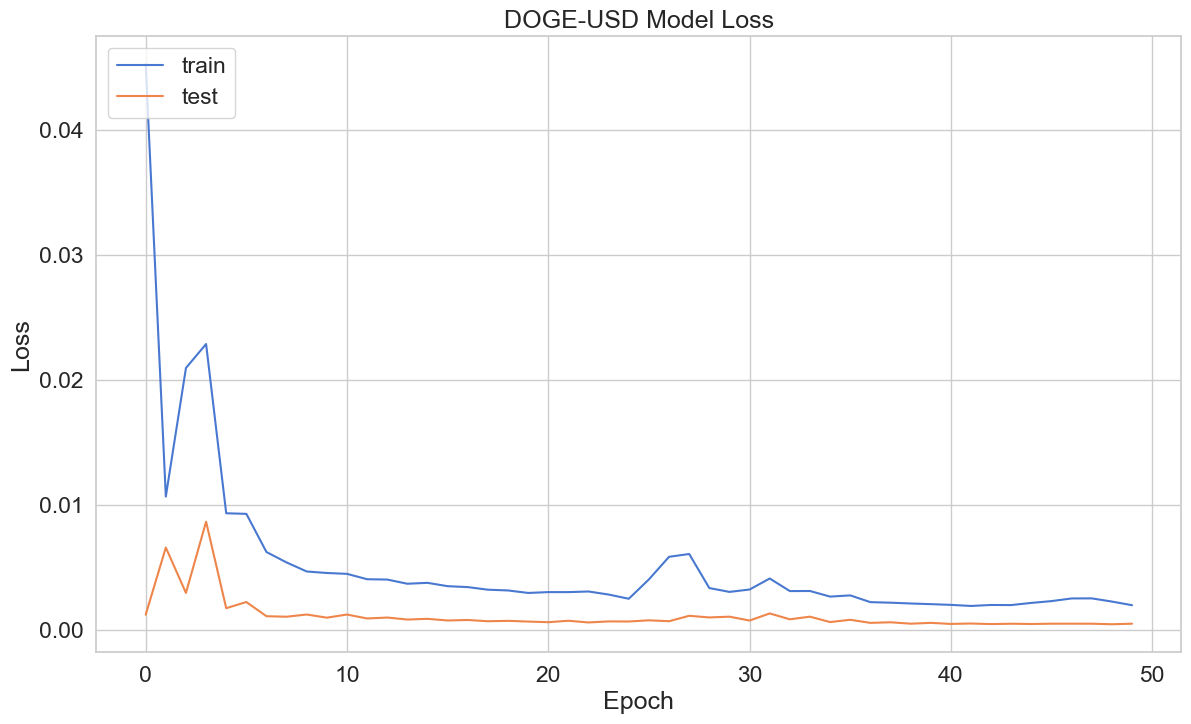

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


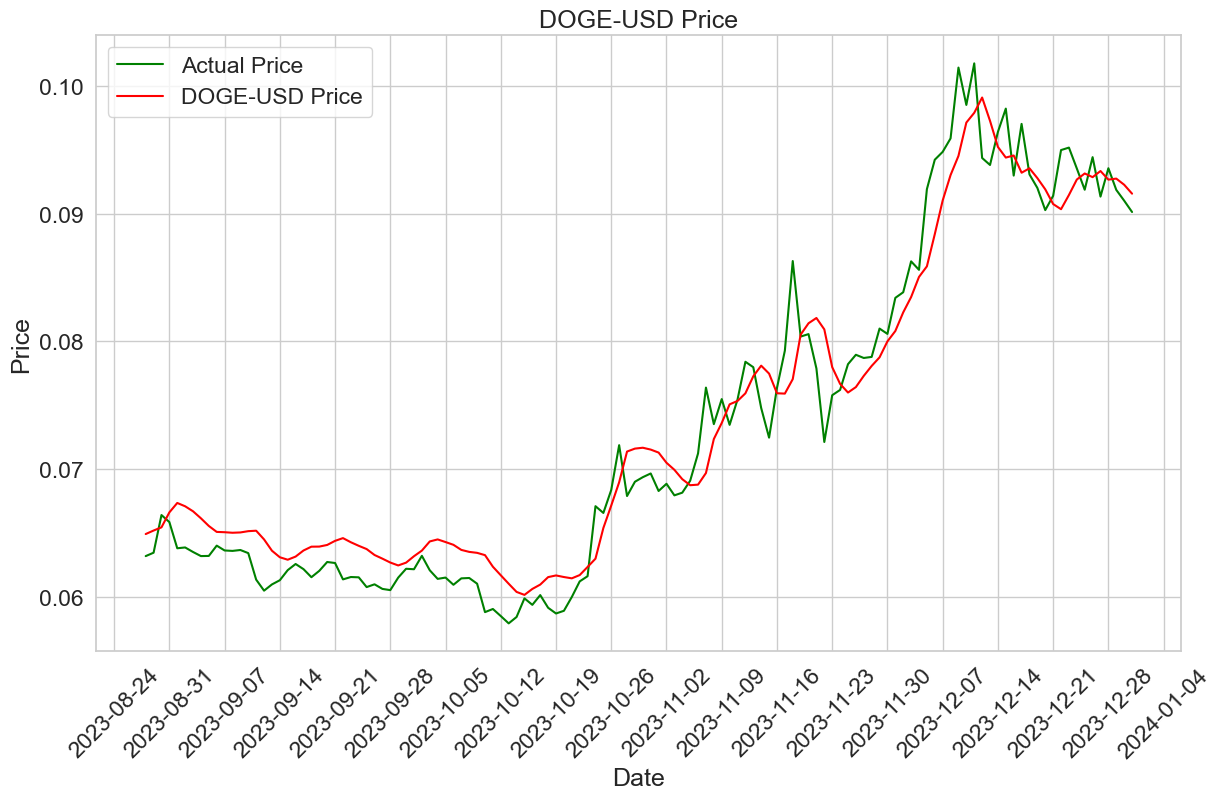

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - loss: 0.0440 - val_loss: 2.2780e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 0.0104 - val_loss: 0.0016
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - loss: 0.0161 - val_loss: 0.0014
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - loss: 0.0275 - val_loss: 0.0054
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 439ms/step - loss: 0.0039 - val_loss: 1.7438e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - loss: 0.0028 - val_loss: 5.5522e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - loss: 0.0042 - val_loss: 1.4993e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 564ms/step - loss: 0.0022 - val_loss: 2.6847e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 476ms/step - loss: 0.0017 - val_loss: 1.3759e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step

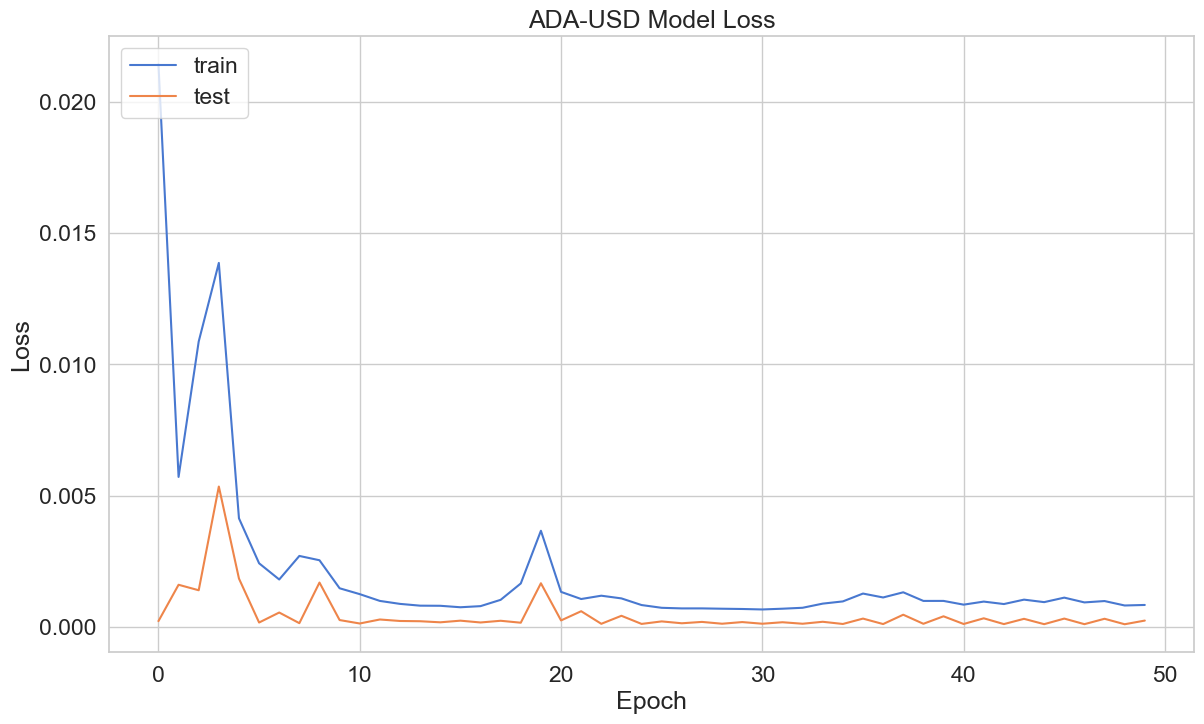

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step


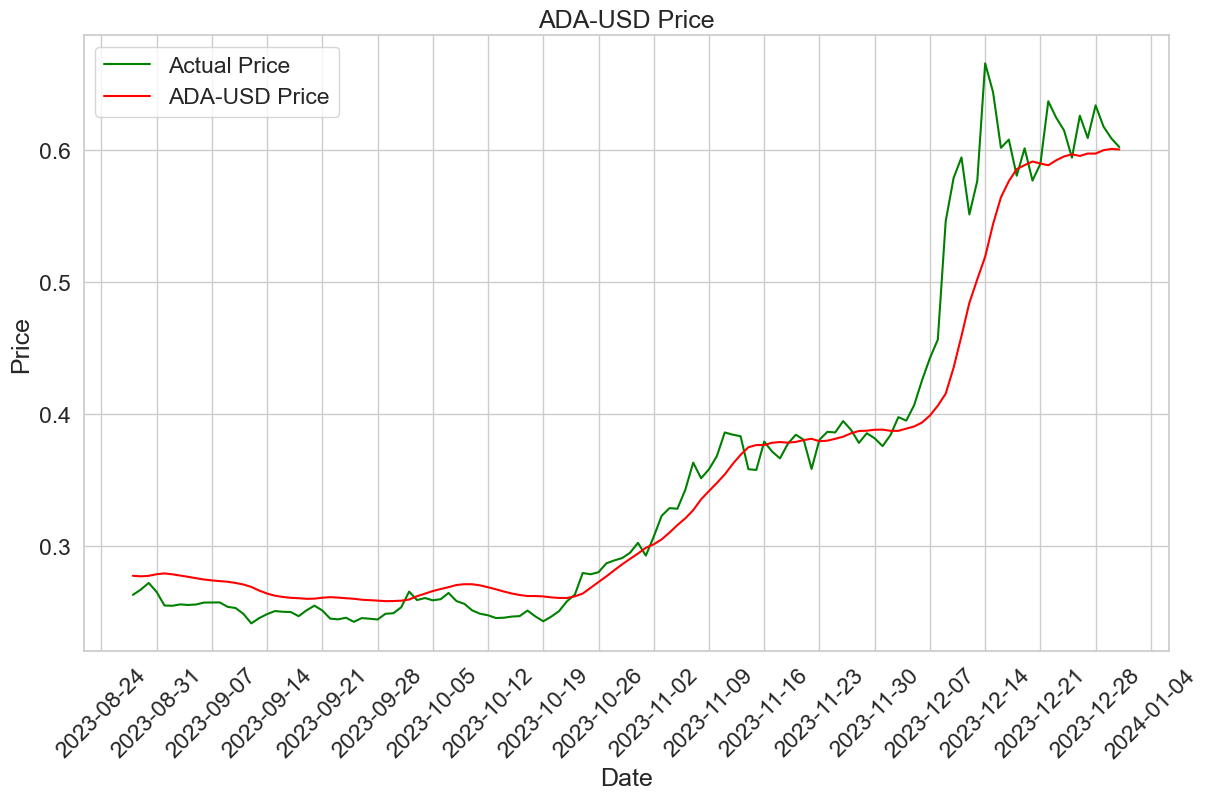

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - loss: 0.0702 - val_loss: 0.0011
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 0.0410 - val_loss: 0.0017
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 0.0454 - val_loss: 0.0095
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.0115 - val_loss: 0.0011
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - loss: 0.0111 - val_loss: 8.2506e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - loss: 0.0052 - val_loss: 9.1400e-04
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - loss: 0.0113 - val_loss: 9.3461e-04
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - loss: 0.0114 - val_loss: 0.0028
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - loss: 0.0

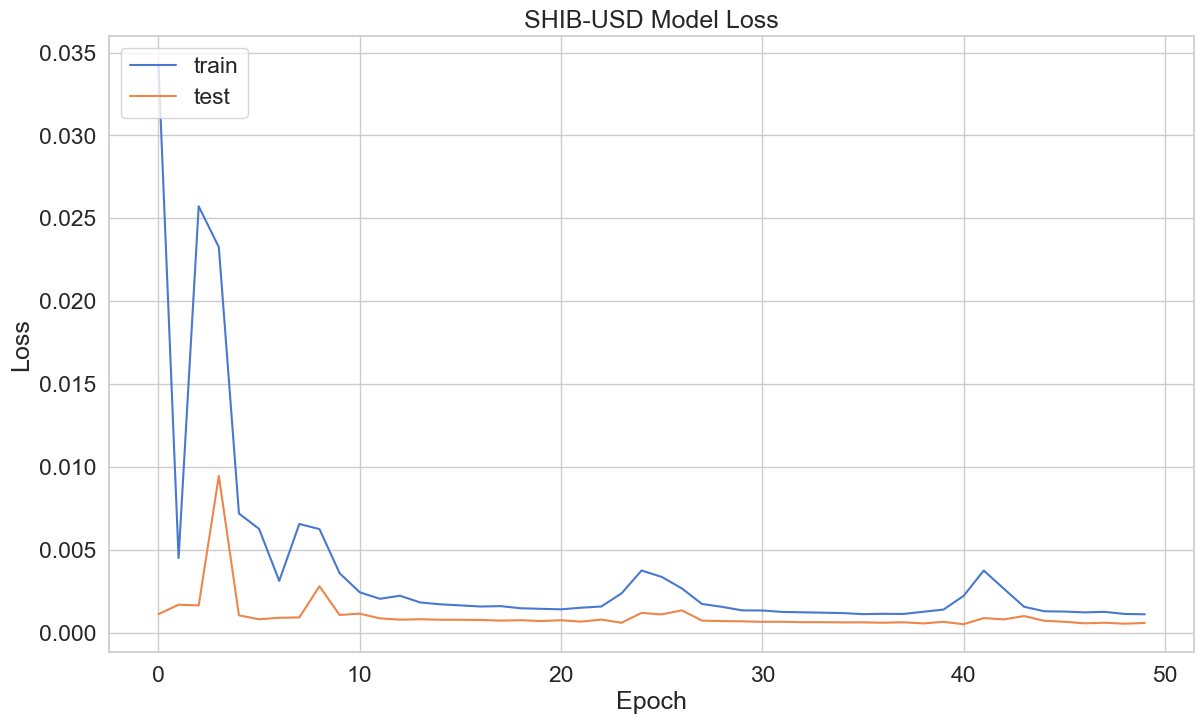

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


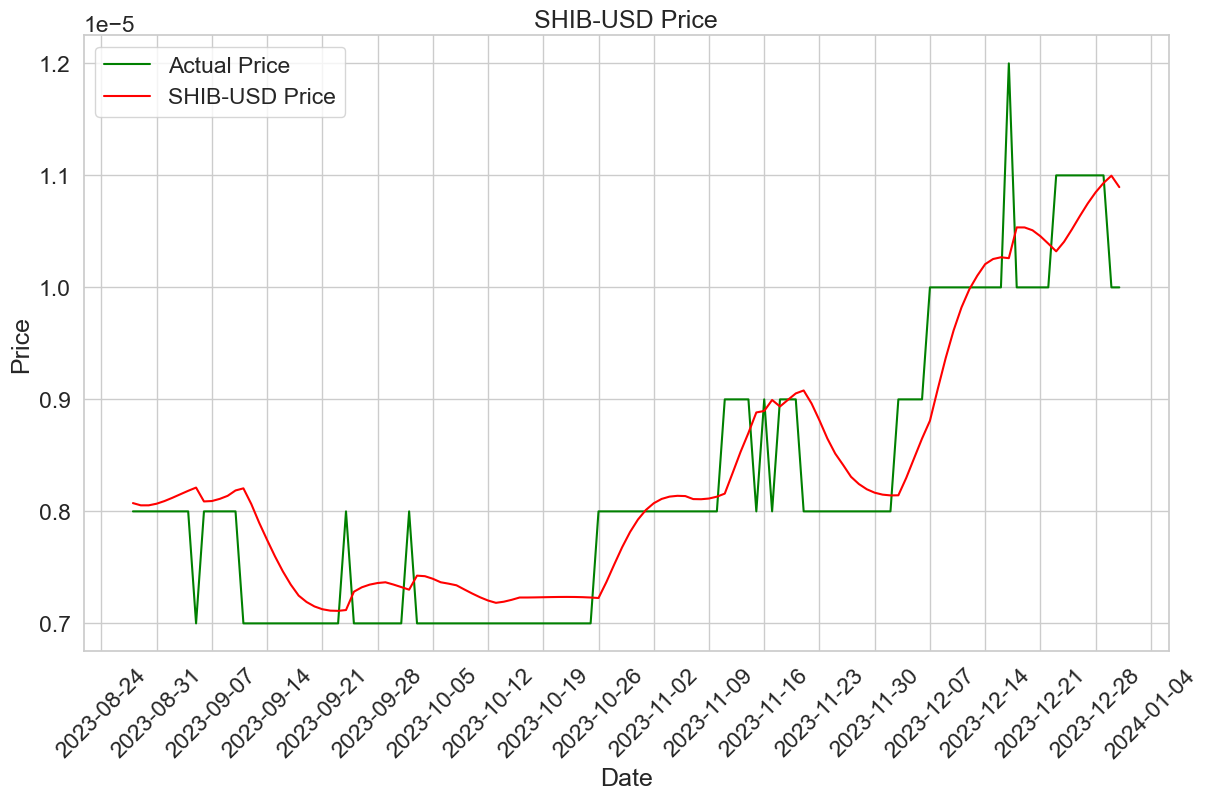

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - loss: 0.0638 - val_loss: 4.6274e-04
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - loss: 0.0086 - val_loss: 4.5372e-05
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.0761 - val_loss: 0.0023
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - loss: 0.0491 - val_loss: 0.0041
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - loss: 0.0157 - val_loss: 0.0021
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - loss: 0.0097 - val_loss: 1.6085e-04
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 0.0079 - val_loss: 8.4475e-05
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - loss: 0.0062 - val_loss: 9.4211e-05
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.0065 - val_loss: 6.6017e-04
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 0.0030 - val_loss: 1.4094e-04
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 0.0022 - val_loss: 1.2364e-04
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 4

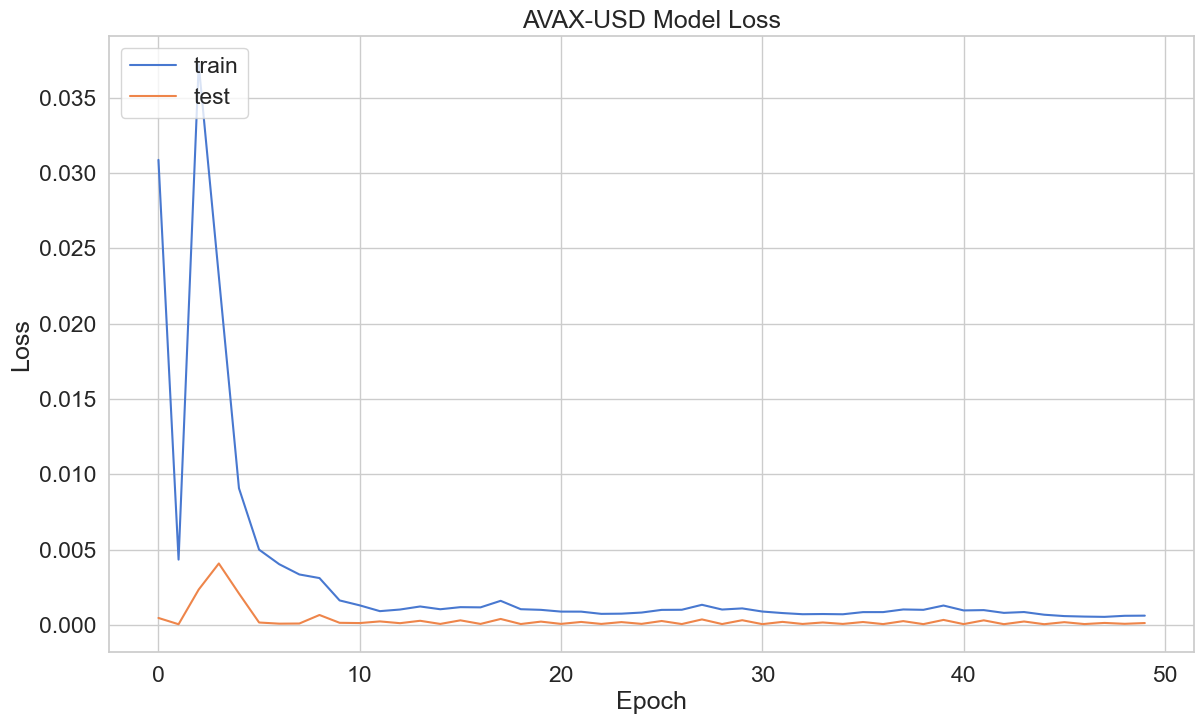

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


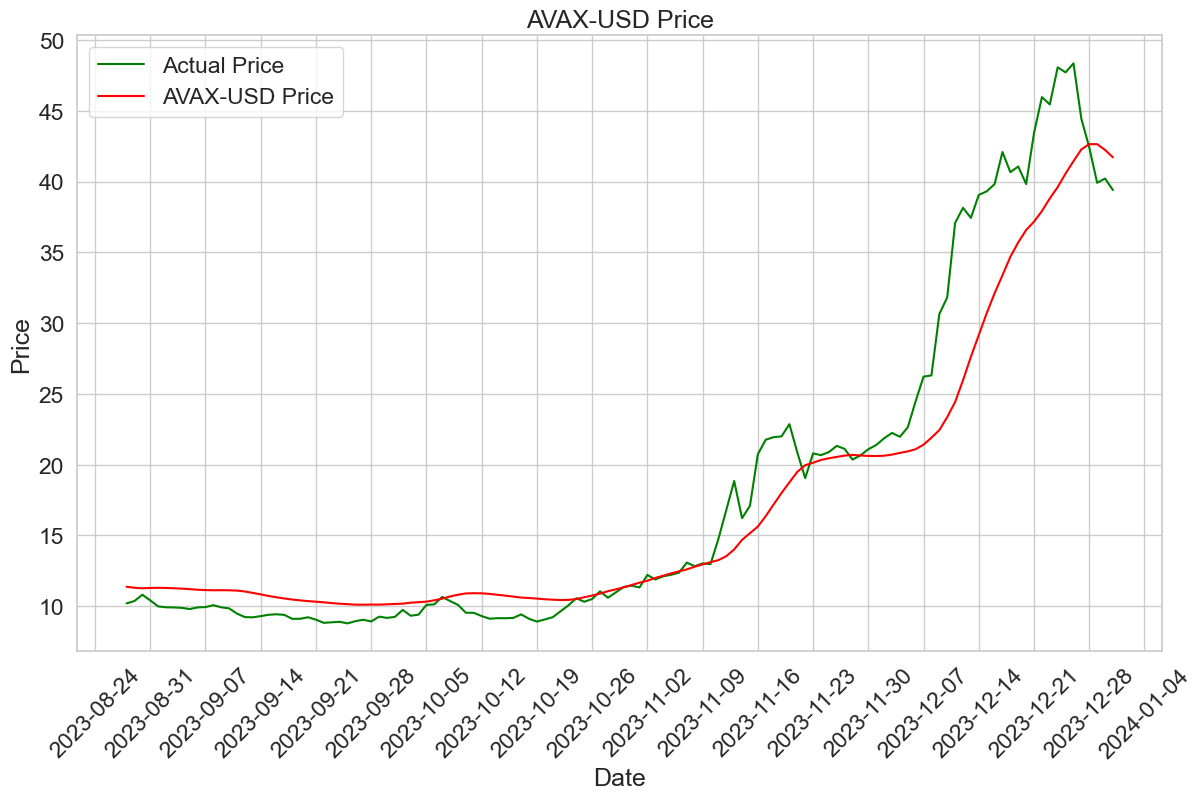

In [15]:
# Main function to iterate over multiple datasets
def main():

    models = {}
    histories = {}
    X_tests = {}
    y_tests = {}
    scalers = {}

    for currency in currencies:
        csv_path = f'./data/{currency}_data.csv'
        df = pd.read_csv(csv_path, parse_dates=['Date'])
        close_price = df['Adj Close'].values.reshape(-1, 1)
        scaled_close = scaler.fit_transform(close_price)
        X_train, y_train, X_test, y_test = preprocess_data(scaled_close, SEQ_LEN, train_split=0.80)
        model, history = train_model(X_train, y_train, X_test, y_test)
        plot_loss(history, scaler, currency, df)
        predict_and_plot(model, X_test, y_test, scaler, currency, df)

        models[currency] = model
        histories[currency] = history
        X_tests[currency] = X_test
        y_tests[currency] = y_test
        scalers[currency] = scaler
    return models, histories, X_tests, y_tests, scalers

# Call the main function
models, histories, X_tests, y_tests, scalers = main()

In [16]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to calculate evaluation metrics
def calculate_metrics(model, X_test, y_test, scaler):
    y_hat = model.predict(X_test)
    y_test_inverse = scaler.inverse_transform(y_test)
    y_hat_inverse = scaler.inverse_transform(y_hat)
    mse = mean_squared_error(y_test_inverse, y_hat_inverse)
    rmse = mean_squared_error(y_test_inverse, y_hat_inverse, squared=False)
    mae = mean_absolute_error(y_test_inverse, y_hat_inverse)
    return mse, rmse, mae

# Main function to compare models
def compare_models(models, histories, currencies):
    evaluation_results = []
    for currency in currencies:
        model = models[currency]
        history = histories[currency]
        X_test = X_tests[currency]
        y_test = y_tests[currency]
        scaler = scalers[currency]
        mse, rmse, mae = calculate_metrics(model, X_test, y_test, scaler)
        evaluation_results.append({'Currency': currency, 'MSE': mse, 'RMSE': rmse, 'MAE': mae})
    return pd.DataFrame(evaluation_results)

# Call the comparison function
evaluation_table = compare_models(models, histories, currencies)
print(evaluation_table)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step 

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
   Currency        MSE      RMSE       MAE
0   BTC-USD  13.187561  3.631468  2.562975
1   ETH-USD   5.004907  2.237165  1.746612
2   SOL-USD  73.325806  8.563049  5.878562
3   BNB-USD  10.491481  3.239056  2.796007
4   XRP-USD  13.265532  3.642188  2.674700
5   TON-USD  19.391739  4.403605  3.044919
6  DOGE-USD   4.999816  2.236027  1.833397
7   ADA-USD   6.431971  2.536133  1.556156
8  SHIB-USD   3.727892  1.930775  1.480984
9  AVAX-USD  12.485993  3.533553  2.257672


/Users/ephraim888sun/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
